# KBL 승부예측 - 1. Binary Classfication Models

In [1]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
RANDOM_SEED = 2022

## 10게임 데이터 전처리

In [56]:
# Colab google drive mount 경로

df = pd.read_csv('recent_avg_record_ver4.csv')
index = ['S18G01N1', 'S26G01N2', 'S26G01N3', 'S28G01N2', 'S28G01N3',
       'S36G01N1', 'S37G13N2', 'S39G13N2', 'S40G01N1']
df[df['gmkey'].isin(index)][['tcode', 'gmkey']]
df = df.drop(index = [540, 3071, 3072, 3693, 3694, 5957, 6588, 7195, 7220])

In [57]:
a_team_data = df[df.index % 2 == 0].reset_index().drop( columns= ['index', 'Unnamed: 0'])
h_team_data = df[df.index % 2 != 0].reset_index().drop( columns= ['index', 'Unnamed: 0'])
a_team_data.to_csv("away_team_data_ver4.csv")
h_team_data.to_csv("home_team_data_ver4.csv")

In [ ]:
# win 컬럼 생성, 이기면 1 지면 0
df_10game['win'] = df_10game['score'] - df_10game['loss']
df_10game.loc[df_10game['score'] > df_10game['loss'], 'win'] = 1
df_10game.loc[df_10game['score'] < df_10game['loss'], 'win'] = 0

In [ ]:
# X, y 분리
X = df_10game.iloc[:, 5:-1]
X.drop(columns=['ef','maxContiScoreCn', 'maxLeadScoreCn', 'playMin', 'playSec', 'scoreHighTimeCn', 'inout', 'inout1', 'idf', 'fb'], inplace=True)
y = df_10game.iloc[:,-1]

In [139]:
def make_model(file_name):
    item = pd.read_csv(file_name, index_col=0)

    result = pd.DataFrame()
    # result['gmkey'] = item['gmkey']
    #게임스코어
    #득점 + 0.4*야투성공개수 - 0.7*야투시도갯수 - 0.4*(자유투시도갯수 - 자유투성공갯수) + 
    #0.7 * 오펜스리바운드 + 0.3 * 디펜스리바운드 + 스틸 + 0.7 * 어시스트 + 0.7 * 블럭 - 0.4 * 개인파울 - 턴오버
    result['gameScore'] = item['avg_score'] + 0.4 * item['fgt'] - 0.7 * item['fgtA'] - 0.4*(item['ftA'] - item['ft']) + \
    0.7 * item['offr'] + 0.3 * item['defr'] + item['stl'] + 0.7 * item['ast'] + 0.7 * item['bs'] - 0.4 * item['foul'] - item['to']

    #승률
    result['winRate'] = -3.590 + 4.112 * item['defr'] + 1.839 * item['fg'] / item['fgA'] + 4.474 * item['stl'] + \
        1.674 * item['threep'] / item['threepA'] - 2.2 * item['to'] + 1.109 * item['ftA'] + 2.320 * item['bs'] + \
        1.812 * item['offr'] + 0.650 * item['ft'] / item['ftA'] + 0.590 * item['ast']

    #팀포제션
    result['teamPossesion'] = item['fgtA'] + 0.44 * item['ftA'] - item['offr'] + item['to']

    #PMG
    result['PMG'] = result['teamPossesion'] - item['fg'] - 0.77*(item['fgA'] - item['fg']) - 0.44 * item['ft'] - \
        0.339 * (item['ftA'] - item['ft']) - item['to'] + 0.77 * item['offr'] + 0.55 * item['ast'] + \
        item['stl'] + 0.23 * item['defr'] + 0.2 * item['foul'] + 0.7 * item['bs']

    #TOR 턴오버 레이팅
    result['TRB'] = (item['to'] * 100) / (item['fgtA'] + item['fgtA'] * 0.44 + item['ast'] + item['to'])


    #KBL Efficiency
    result['Efficiency'] = (item['avg_score'] + item['stl'] + item['bs'] + \
        item['defr']) + (item['offr'] + item['ast'] + item['gd']) * 1.5 - \
            (item['to'] * 1.5 + item['fgA'] - item['fg'] + (item['threepA'] - item['threep']) * 0.9 + \
            (item['ftA'] - item['ft']) * 0.8)

    # result['win'] = item['gm_score'] > item['gm_loss']
    
    return result, item['gm_score'] > item['gm_loss']
    # X = result.iloc[:, :-1]
    # y = result.iloc[:, -1]
    # return X, y

In [202]:
home_data, win = make_model('home_team_data_ver4.csv')
away_data, _ = make_model('away_team_data_ver4.csv')


In [203]:
pd.concat([home_data, away_data], axis=1).to_csv('concat_data_ver4.csv')

In [204]:
# data = pd.read_csv('concat_data_ver4.csv', index_col=0)
data = home_data / away_data
data['win'] = win
# data.to_csv('concat_data_sub_ver.csv')

In [205]:
# data = data.drop(columns=['PMG', 'TRB', 'teamPossesion'])
data = data.drop(columns=['TRB'])
y = data.iloc[:, -1]
X = data.iloc[:, :-1]

In [206]:
# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [207]:
# Standard Scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns)
X_train_scaled

scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)

## 1. Random Forest
- Grid Search로 hyper parameter 튜닝

In [208]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param = {
    'n_estimators': [200, 250],
    'max_depth': [7, 8],
    'min_samples_leaf': [6, 7],
    'min_samples_split': [2],
    'n_jobs': [-1]
    # 'random_state': [RANDOM_SEED]
}

model = RandomForestClassifier()
grid = GridSearchCV(model, param, refit=True, verbose=2)

In [209]:
from sklearn import svm
from sklearn.metrics import accuracy_score

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred_scaled = clf.predict(X_test_scaled)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_scaled)

(0.6131687242798354, 0.6063100137174211)

In [211]:
grid.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=200, n_jobs=-1; total time=   0.3s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=200, n_jobs=-1; total time=   0.2s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=200, n_jobs=-1; total time=   0.2s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=200, n_jobs=-1; total time=   0.3s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=200, n_jobs=-1; total time=   0.3s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=250, n_jobs=-1; total time=   0.3s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=250, n_jobs=-1; total time=   0.3s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=250, n_jobs=-1; total time=   0.3s
[CV] END max_depth=7, min_samples_leaf=6, min_sample

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 8], 'min_samples_leaf': [6, 7],
                         'min_samples_split': [2], 'n_estimators': [200, 250],
                         'n_jobs': [-1]},
             verbose=2)

In [212]:
print("Best avg score : ", grid.best_score_)
print("Best params : ", grid.best_params_)

Best avg score :  0.5960932020064484
Best params :  {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1}


Feature importance 시각화

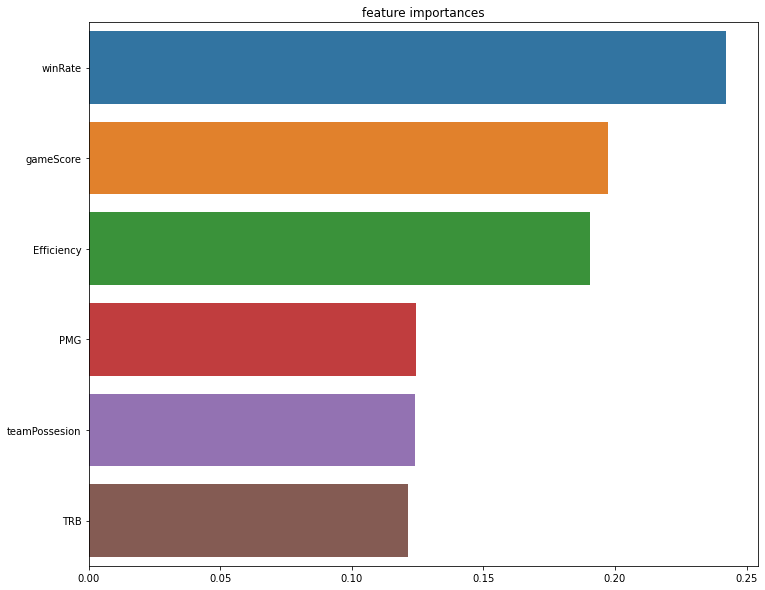

In [182]:
rf = grid.best_estimator_
feature_importances = rf.feature_importances_

ft_importances = pd.Series(feature_importances, index=X_train_scaled.columns)
ft_importances.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 10))
plt.title("feature importances")
sns.barplot(x=ft_importances, y=ft_importances.index)
plt.show()

## 2. Gradient Boosting
- Grid Search로 hyper parameter 튜닝

In [186]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param = {
    'learning_rate': [0.03, 0.05],
    'n_estimators': [100, 200],
    'min_samples_leaf': [6, 7],
    # 'max_depth': [3, 5, 7, 9]
    # 'random_state': [RANDOM_SEED]
}

model = GradientBoostingClassifier()
grid = GridSearchCV(model, param, refit=True, verbose=2)

In [187]:
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END learning_rate=0.03, min_samples_leaf=6, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.03, min_samples_leaf=6, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.03, min_samples_leaf=6, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.03, min_samples_leaf=6, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.03, min_samples_leaf=6, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.03, min_samples_leaf=6, n_estimators=200; total time=   0.7s
[CV] END learning_rate=0.03, min_samples_leaf=6, n_estimators=200; total time=   0.7s
[CV] END learning_rate=0.03, min_samples_leaf=6, n_estimators=200; total time=   0.7s
[CV] END learning_rate=0.03, min_samples_leaf=6, n_estimators=200; total time=   0.7s
[CV] END learning_rate=0.03, min_samples_leaf=6, n_estimators=200; total time=   0.7s
[CV] END learning_rate=0.03, min_samples_leaf=7, n_estimators=100; total time=  

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.03, 0.05],
                         'min_samples_leaf': [6, 7],
                         'n_estimators': [100, 200]},
             verbose=2)

In [188]:
print("Best avg score : ", grid.best_score_)
print("Best params : ", grid.best_params_)

Best avg score :  0.5905919730272968
Best params :  {'learning_rate': 0.03, 'min_samples_leaf': 6, 'n_estimators': 100}


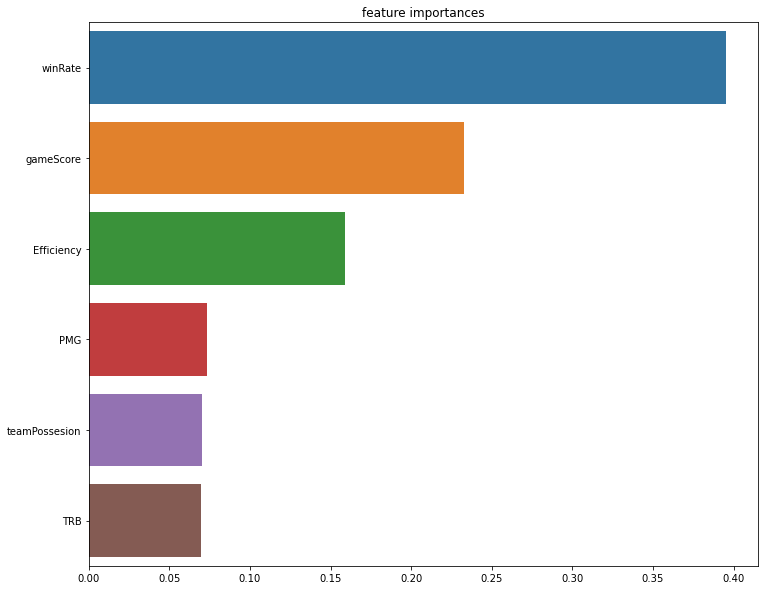

In [189]:
rf = grid.best_estimator_
feature_importances = rf.feature_importances_

ft_importances = pd.Series(feature_importances, index=X_train_scaled.columns)
ft_importances.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 10))
plt.title("feature importances")
sns.barplot(x=ft_importances, y=ft_importances.index)
plt.show()

## 3. AdaBoost
- Grid Search로 hyper parameter 튜닝

In [190]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

param = {
    'learning_rate': [0.05, 0.07, 0.09],
    'n_estimators': [100, 200, 300],
    'random_state': [RANDOM_SEED]
}

model = AdaBoostClassifier()
grid = GridSearchCV(model, param, refit=True, verbose=2)

In [191]:
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END learning_rate=0.05, n_estimators=100, random_state=2022; total time=   0.4s
[CV] END learning_rate=0.05, n_estimators=100, random_state=2022; total time=   0.3s
[CV] END learning_rate=0.05, n_estimators=100, random_state=2022; total time=   0.4s
[CV] END learning_rate=0.05, n_estimators=100, random_state=2022; total time=   0.4s
[CV] END learning_rate=0.05, n_estimators=100, random_state=2022; total time=   0.3s
[CV] END learning_rate=0.05, n_estimators=200, random_state=2022; total time=   0.5s
[CV] END learning_rate=0.05, n_estimators=200, random_state=2022; total time=   0.6s
[CV] END learning_rate=0.05, n_estimators=200, random_state=2022; total time=   0.5s
[CV] END learning_rate=0.05, n_estimators=200, random_state=2022; total time=   0.6s
[CV] END learning_rate=0.05, n_estimators=200, random_state=2022; total time=   0.6s
[CV] END learning_rate=0.05, n_estimators=300, random_state=2022; total time=   0.9s
[CV] 

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.05, 0.07, 0.09],
                         'n_estimators': [100, 200, 300],
                         'random_state': [2022]},
             verbose=2)

In [192]:
print("Best avg score : ", grid.best_score_)
print("Best params : ", grid.best_params_)

Best avg score :  0.5957401283796927
Best params :  {'learning_rate': 0.09, 'n_estimators': 100, 'random_state': 2022}


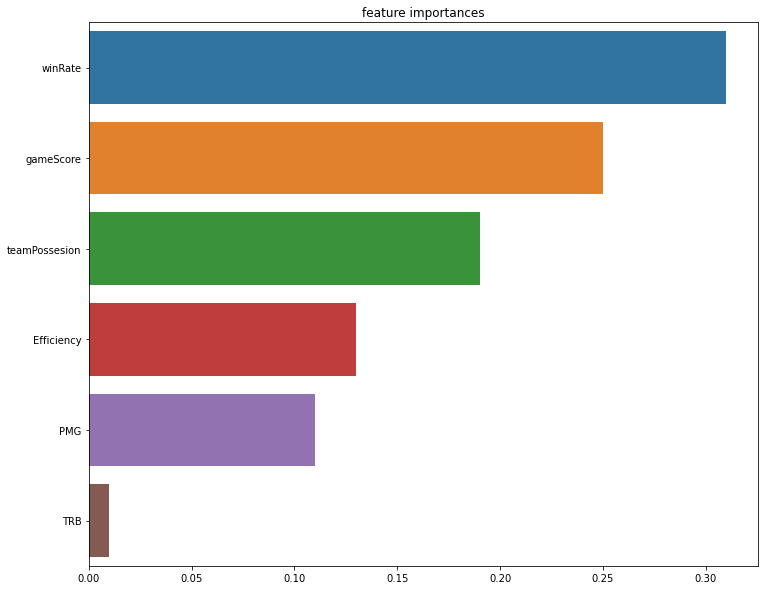

In [193]:
rf = grid.best_estimator_
feature_importances = rf.feature_importances_

ft_importances = pd.Series(feature_importances, index=X_train_scaled.columns)
ft_importances.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 10))
plt.title("feature importances")
sns.barplot(x=ft_importances, y=ft_importances.index)
plt.show()